#### TensorFlow

In [1]:
#import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()

# Bi-LSTM(Attention) Parameters
embedding_dim = 2
n_hidden = 5 # number of hidden units in one cell
n_step = 3 # all sentence is consist of 3 words
n_class = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

W0603 21:29:47.255136 27288 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
input_batch = []
for sen in sentences:
    input_batch.append(np.asarray([word_dict[n] for n in sen.split()]))

target_batch = []
for out in labels:
    target_batch.append(np.eye(n_class)[out]) # ONE-HOT : To using Tensor Softmax Loss function

# LSTM Model
X = tf.placeholder(tf.int32, [None, n_step])
Y = tf.placeholder(tf.int32, [None, n_class])
out = tf.Variable(tf.random_normal([n_hidden * 2, n_class]))

embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_dim]))
input = tf.nn.embedding_lookup(embedding, X) # [batch_size, len_seq, embedding_dim]

lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(n_hidden)
lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(n_hidden)

# output : [batch_size, len_seq, n_hidden], states : [batch_size, n_hidden]
output, final_state = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell, input, dtype=tf.float32)

# Attention
output = tf.concat([output[0], output[1]], 2)                             # output[0] : lstm_fw, output[1] : lstm_bw
final_hidden_state = tf.concat([final_state[1][0], final_state[1][1]], 1) # final_hidden_state : [batch_size, n_hidden * num_directions(=2)]
final_hidden_state = tf.expand_dims(final_hidden_state, 2)                # final_hidden_state : [batch_size, n_hidden * num_directions(=2), 1]

attn_weights = tf.squeeze(tf.matmul(output, final_hidden_state), 2) # attn_weights : [batch_size, n_step]
soft_attn_weights = tf.nn.softmax(attn_weights, 1)
context = tf.matmul(tf.transpose(output, [0, 2, 1]), tf.expand_dims(soft_attn_weights, 2)) # context : [batch_size, n_hidden * num_directions(=2), 1]
context = tf.squeeze(context, 2) # [batch_size, n_hidden * num_directions(=2)]

model = tf.matmul(context, out)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Model-Predict
hypothesis = tf.nn.softmax(model)
predictions = tf.argmax(hypothesis, 1)

W0603 21:30:00.746817 27288 deprecation.py:323] From <ipython-input-2-3bfc1e53f138>:17: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0603 21:30:00.748325 27288 deprecation.py:323] From <ipython-input-2-3bfc1e53f138>:21: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
W0603 21:30:00.749328 27288 deprecation.py:323] From C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\rnn.py:464: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0

Epoch: 001000 cost = 0.000948
Epoch: 002000 cost = 0.000195
Epoch: 003000 cost = 0.000074
Epoch: 004000 cost = 0.000036
Epoch: 005000 cost = 0.000019
sorry hate you is Bad Mean...


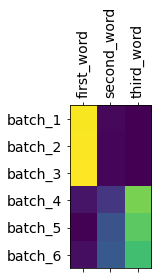

In [3]:
# Training
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(5000):
        _, loss, attention = sess.run([optimizer, cost, soft_attn_weights], feed_dict={X: input_batch, Y: target_batch})
        if (epoch + 1)%1000 == 0:
            print('Epoch:', '%06d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]

    predict = sess.run([predictions], feed_dict={X: tests})
    result = predict[0][0]
    if result == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + ['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels([''] + ['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()

#### PyTorch

In [4]:
#import
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

# Bi-LSTM(Attention) Parameters
embedding_dim = 2
n_hidden = 5 # number of hidden units in one cell
num_classes = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

In [5]:
inputs = []
for sen in sentences:
    inputs.append(np.asarray([word_dict[n] for n in sen.split()]))

targets = []
for out in labels:
    targets.append(out) # To using Torch Softmax Loss function

input_batch = Variable(torch.LongTensor(inputs))
target_batch = Variable(torch.LongTensor(targets))

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = Variable(torch.zeros(1*2, len(X), n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = Variable(torch.zeros(1*2, len(X), n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

model = BiLSTM_Attention()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 1000 cost = 0.004476
Epoch: 2000 cost = 0.000917
Epoch: 3000 cost = 0.000343
Epoch: 4000 cost = 0.000167
Epoch: 5000 cost = 0.000090
sorry hate you is Bad Mean...


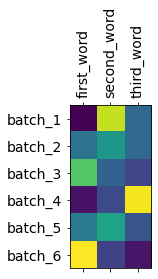

In [6]:
# Training
for epoch in range(5000):
    optimizer.zero_grad()
    output, attention = model(input_batch)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = Variable(torch.LongTensor(tests))

# Predict
predict, _ = model(test_batch)
predict = predict.data.max(1, keepdim=True)[1]
if predict[0][0] == 0:
    print(test_text,"is Bad Mean...")
else:
    print(test_text,"is Good Mean!!")
    
fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='viridis')
ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
plt.show()